# Lecture 09: Practical analyses in Python (continued)

## Biopython
[Biopython](https://biopython.org/) is a package that has lots of useful functions for computational biology.

It is very handy for things like reading in sequences in many different formats: [Bio.SeqIO](https://biopython.org/wiki/SeqIO) is your friend!

(Do note that if you are analyzing truly large datasets, `Biopython` is not very fast and you may want to use something like [pysam](https://pysam.readthedocs.io/en/latest/api.html); but `Biopython` is a good starting point).

### Reading in a file
I have included the file [barcodes_R1.fastq](barcodes_R1.fastq), which has some FASTQ sequences in it.

First, let's just see what the beginning of that file looks like (FASTQ format is explained in detail [here](https://en.wikipedia.org/wiki/FASTQ_format)):

In [1]:
! head -n 8 barcodes_R1.fastq

@HISEQ:621:HMJGNBCX2:1:1101:1797:2150 1:N:0:ATGTCA
GCTTAAGTTATTTAGTGCGGCCGCCTATGGTGCACTATTATTTATCTATCGTGAAAGGGAGTTCTGCTCCATCAGGCCAAGATCGGAAGAGCACACGTCTGAACTCCAGTCACATGTCAGAATCTCGTATGCCGTCTTCTGCTTGAAAAAAAAAAAAAAGCTGAAATTAATAATTTTGAAACCAGTTTTGTAAACGCAGCACTAAAATGAAGGCATGCAACGACGATGTTTATTGACACGGAATAGCAGA
+
GGGGGGIIIGIIIIGIIIIGIIIIIIIGGIGIIIIIIIIIGIIIIGGIIIGIGIIIGGIIIIGIIIIGIIIIIIIIIIIIIGIIIIIIIIGIIIIIGGIIIIGGGGIGAGGIGGGGGIGIII<AGGGIIGGIIGGIGIGGAGIGGIGGGGIIIIGA##############################################################################################
@HISEQ:621:HMJGNBCX2:1:1101:9239:2123 1:N:0:ATGTCA
CTTCCTGGTCACGGTTGCGGCCGCCTATGGTGCATCATTATATGCAAATCCGGCATTGCAAGGAGCCGTTGGAACACATAGATCGGAAGAGCACACGTCTGAACTCCAGTCACATGTCAGAATCTCGTATGCCGTCTTCTGCTTGAAAAAAAAAAAAAAAACCTAAATAGGTATCATAAAGACACCATCAACAGCTTAGTATACAACCCCATGCATTAAACAAATACATCCCTAATGACAGAGTGTACGA
+
GGGGGGIIIIGGGGGGIIIIIIIIIIIIGIIIIIIIGGGGGGIIGAGGIGGGIIGIIIIGIIGGIIIIIGIGGIIIGIIGGIIIIIIIGGGGGAGGIGGGIGGIGGGGGGIIGGGGGGGGGG<<AGGAGGGGGGGIIGAAA

Now let's use `Biopython` to read the FASTQ entries.

First, import `Biopython.SeqIO`:

In [2]:
import re

import Bio.SeqIO

Now read in the sequencing reads:

In [3]:
seqreads = list(Bio.SeqIO.parse('barcodes_R1.fastq', format='fastq'))

How many reads were there?

In [4]:
print(f"Found {len(seqreads)} sequencing reads.")

Found 10000 sequencing reads.


Let's look at the first read:

In [5]:
seqreads[0]

SeqRecord(seq=Seq('GCTTAAGTTATTTAGTGCGGCCGCCTATGGTGCACTATTATTTATCTATCGTGA...AGA'), id='HISEQ:621:HMJGNBCX2:1:1101:1797:2150', name='HISEQ:621:HMJGNBCX2:1:1101:1797:2150', description='HISEQ:621:HMJGNBCX2:1:1101:1797:2150 1:N:0:ATGTCA', dbxrefs=[])

You can see that `BioPython` reads the sequences in as [SeqRecord](https://biopython.org/wiki/SeqRecord) objects, which have a lot of information, including the header, quality scores, etc.

For our purposes, we will just convert the sequence part into a string for each sequence:

In [6]:
seqreads_str = [str(s.seq) for s in seqreads]

Notice how the above cell used a [list comprehension](https://www.pythonforbeginners.com/basics/list-comprehensions-in-python).
Write the same code as a for loop and verify that it gives the same result:

In [7]:
# your code here ... (name your new list `seqreads_str_2`)


In [8]:
# make sure `seqreads_str` and `seqreads_str_2` have all identical entries
assert len(seqreads_str) == len(seqreads_str_2)
for i in range(len(seqreads_str)):
    s1 = seqreads_str[i]
    s2 = seqreads_str_2[i]
    assert s1 == s2

Make sure we still have the same number of sequencing reads, and look at the first one:

In [9]:
assert len(seqreads_str) == len(seqreads)

seqreads_str[0]

'GCTTAAGTTATTTAGTGCGGCCGCCTATGGTGCACTATTATTTATCTATCGTGAAAGGGAGTTCTGCTCCATCAGGCCAAGATCGGAAGAGCACACGTCTGAACTCCAGTCACATGTCAGAATCTCGTATGCCGTCTTCTGCTTGAAAAAAAAAAAAAAGCTGAAATTAATAATTTTGAAACCAGTTTTGTAAACGCAGCACTAAAATGAAGGCATGCAACGACGATGTTTATTGACACGGAATAGCAGA'

## A real biological analysis: parsing barcodes
<a id='real_analysis'></a>
The reads that we just read as `seqreads_str` come from a real sequencing run of influenza virus HA and NA genes.

The sequences are as follows:

    5'-[end of HA]-AGGCGGCCGC-[16 X N]-3'
    
or 

    5'-[end of NA]-AGGCGGCCGC-[16 X N]-3'
    
The end of NA is:

    ...CACGATAGATAAATAATAGTGCACCAT
    
The end of HA is:

    ...CCGGATTTGCATATAATGATGCACCAT
    
The sequencing run reads from the reverse end of the molecules, so the first thing in the sequencing reads is the reverse complement of the barcode followed by the constant sequence and the end of HA or NA.

We want to determine which reads have valid sequences, get the barcodes out of strings, figure out if the barcode matches to HA or NA, and count the barcodes.
So this requires setting up an analysis that does the following:

 1. Get the reverse complement of each read.
 2. Determine if it matches the expected pattern for HA and NA, and if so which one.
 3. If it matches, extract the barcode and add it to a dictionary to keep track of counts.
 4. Determine the number and distribution of barcodes for HA and NA separately.

### Group activity
In groups, work together to write some code to do most of this but **not** distinguishing among whether the barcode matches HA or NA.
I have created a code chunk for each step (with some parts filled in). 
Remember to run the code chunks in the correct order!

For your homework, you will be asked to extend this in-class analysis to get statistics for HA and NA seperately.

In [ ]:
# load necessary packages
import re
import Bio.SeqIO

__Step 1:__ You'll need to write two functions: (1) a function that gets the reverse complement of a DNA sequence and (2) a function that identifies a barcode with a known upstream sequence. 
I've provided the documentation for each function here.

_Hint: you wrote similar functions to these on Tuesday--feel free to copy your code over and adapt it as needed_

In [ ]:
def reverse_complement(seq):
    """Get reverse complement of a DNA sequence.
    
    Parameters
    -----------
    seq : str
        Uppercase DNA sequence.
        
    Returns
    -------
    str
        Reverse complement of the sequence in upper case.
        
    Example
    --------
    >>> reverse_complement('ATGCAC')
    'GTGCAT'
    
    """
    # your code here...
    
    return None

In [ ]:
def read_barcode(seqread, bclen, upstream='AGGCGGCCGC'):
    """Identify barcode with known upstream sequence.
    
    Parameters
    ----------
    seqread : str
        Nucleotide sequence matching UPSTREAM-BARCODE read in reverse orientation.
    bclen : int
        Length of barcode
    upstream: str
        Sequence upstream of the barcode.
        
    Returns
    -------
    str or None
        Sequence of the barcode in the forward orientation, or `None` if no match to expected barcoded sequence.
        
    Example
    -------
    >>> read_barcode('TTTTTTTTTTTTTTTTGCGGCCGCCT', bclen=16)
    'AAAAAAAAAAAAAAAA'
        
    """
    # your code here ...
    
    return None

__Step 2:__ Read sequences _(note: we already did this step earlier)_

In [ ]:
# run this code chunk...
seqreads = list(Bio.SeqIO.parse('barcodes_R1.fastq', 'fastq'))
seqreads_str = [str(seqrecord.seq) for seqrecord in seqreads]

__Step 3:__ Get the counts of all barcodes. _(Hint: you might want to store barcodes and counts in a dictionary, and also keep track of the number of sequences that don't have a valid barcode)_

Please name your dictionary `barcode_counts`

In [21]:
# your code here ...


__Step 4:__ Report the total number of sequences parsed, and how many lacked a valid barcode.

In [ ]:
# your code here ...


### Creating a data frame with the barcode counts
We create a [pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) with the barcode counts.
These data frames are a great way to represent any information that can ultimately be thought of in tabular form.

In [11]:
import pandas

barcode_counts_df = pandas.Series(barcode_counts).reset_index()

barcode_counts_df.columns = ['barcode', 'count']

barcode_counts_df

,barcode,count
0,ACTAAATAACTTAAGC,63
1,AACCGTGACCAGGAAG,70
2,CCACATTCATCGCTGA,30
3,TTATCGTCTCCCATAT,78
4,CTACCCGTTTCCCAAC,124
...,...,...
430,ATTGCATGACTACAAC,1
431,TTACGATCCTCAAGAA,1
432,GCACATAAGGAGCCAA,1
433,AATACGAACATATCGG,1


Looking at a few entries in a data frame: the [head](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.head.html) and [tail](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.tail.html) commands:

In [12]:
barcode_counts_df.tail()

,barcode,count
430,ATTGCATGACTACAAC,1
431,TTACGATCCTCAAGAA,1
432,GCACATAAGGAGCCAA,1
433,AATACGAACATATCGG,1
434,GCTACTACTATACCTT,1


Sorting a data frame: the [sort_values](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html) command:

In [13]:
barcode_counts_df.sort_values('count', ascending=False)

,barcode,count
31,CCCGACCCGACATTAA,158
49,ACCAGTTCTCCCCGGG,154
27,TCAAGAAGCCTTGGAG,152
48,TGACGATCCTCAAGAA,145
8,CGTCTTCCATCCCCAT,136
...,...,...
281,ACTAAAGAACTTAAGC,1
282,TGACATAGCGAGACGG,1
283,CGAATCTGCGCAATCC,1
284,TGGGCAATAAACGTAG,1


### Plotting the data frame
Python has lots of ways to make plots:

 - [matplotlib](https://matplotlib.org/): The base Python plotting library, you can do almost anything with it.
 - [seaborn](https://seaborn.pydata.org/): Useful to easily make certain kinds of complex scientific plots.
 - [Altair](https://altair-viz.github.io/): Developed at University of Washington, great for making **interactive** plots.
 
We aren't going to use any of those, but feel free to explore them on your own--instead we are going to [plot directly from pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html)
This is a useful strategy if you have a data frame and need a quick and simple plot.

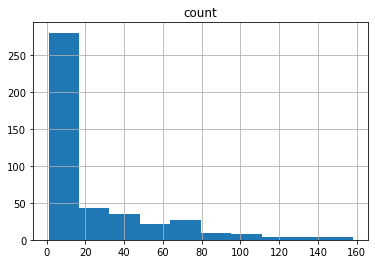

In [15]:
# use pandas built in plotting

fig = barcode_counts_df.hist('count')

### Faceting the plot
What if we had barcode counts for several **different** categories (such as genes)?

Here we do this on made up data, where we simply imagine that our same data multiplied by two is a second category.

First, we now make a merged data frame with the original data and the data multiplied by two.
Note how we do this using the [pandas.concat](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html) function, and how we use [assign](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.assign.html) to add the dummy variable to each data frame:

In [23]:
copy1 = barcode_counts_df.assign(dummy_variable='category_1')
copy2 = barcode_counts_df.assign(dummy_variable='category_2')

dummy_df = pandas.concat([copy1, copy2]).reset_index(drop=True)

dummy_df

,barcode,count,dummy_variable
0,ACTAAATAACTTAAGC,63,category_1
1,AACCGTGACCAGGAAG,70,category_1
2,CCACATTCATCGCTGA,30,category_1
3,TTATCGTCTCCCATAT,78,category_1
4,CTACCCGTTTCCCAAC,124,category_1
...,...,...,...
865,ATTGCATGACTACAAC,1,category_2
866,TTACGATCCTCAAGAA,1,category_2
867,GCACATAAGGAGCCAA,1,category_2
868,AATACGAACATATCGG,1,category_2


Now facet the plot using the `by` argument:

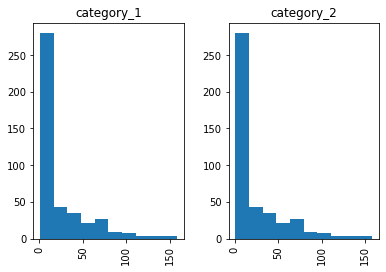

In [24]:
fig2 = dummy_df.hist('count', by = 'dummy_variable')